In [1]:
import cv2 as cv
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/High Statistic/simu_Analysis_elec_2.5MeV.root")
file.keys()

['T;34', 'T;33', 'pmt;2', 'pmt;1']

In [4]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

In [5]:
data1 = file['T;34']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

## 1.1 - EV info

In [6]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
energy = np.array(data1['energy'])
#mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.2 - PMT info

In [7]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Select Data

## 2.1 - Extract  valid PMT id

In [8]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([       0,        1,        2, ..., 72087723, 72087724, 72087725],
      dtype=int64)

### 2.1.1 - Extraer información valida de PMT info

In [9]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [10]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 5
#time cut
inf_cut = -5
up_cut = 15

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
#multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    #multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        #multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    #multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        #multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
#multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
computing cos(alpha)
doing time residual cuts


# 2.3 - Separate Event Information 

In [11]:
break_i = [0] #List of indices where data change of event ID

N_evts = len(multi_mc_ID_cut)
for i in range(N_evts-1):
    if multi_mc_ID_cut[i] != multi_mc_ID_cut[i+1]:
        break_i.append(i+1)    
break_i = np.array(break_i, dtype = np.int32)

# 3 - Observe 2DHist for Δ vs. α - MultiEV/Single EV

In [79]:
#Escoger un eventID para observar y hacer match

i = break_i[2]
f = break_i[3]

#multi_mc_ID_cut[i:f]

#select event data
time_residual_ev = np.array(multi_time_residual_cut[i:f])
cos_angel_ev = np.array(multi_cos_angle_cut[i:f])

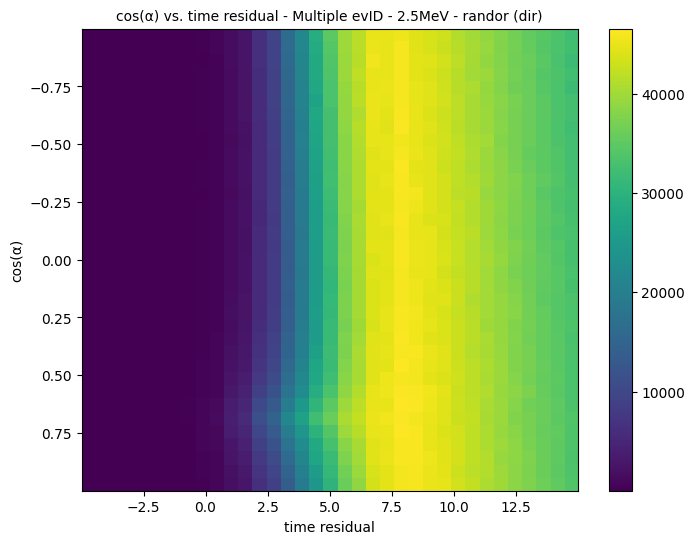

In [100]:
bins = 35

if radi_cut_method == True:
    title = 'cos(α) vs. time Residual Multiple evID - 2.5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'cos(α) vs. time residual - Multiple evID - 2.5MeV - randor (dir)'


xlabel = 'time residual'
ylabel = 'cos(α)'

H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y =  multi_time_residual_cut, bins = [bins, bins])

# plot limits
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

plt.figure(figsize=(8,6))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()

# 4 - Recognition using Templates

## 4.1 - Load and Loop Over Templates and Events

In [116]:
#Loop over events

#Choose number of events
N_evs = 19                                      #real number of events is N_evs + 1
index_list = np.arange(0,N_evs + 1,1)

for ev_i in index_list:

    #consecutive single events
    i = break_i[ev_i]
    f = break_i[ev_i+1]
    time_residual_ev = np.array(multi_time_residual_cut[i:f])
    cos_angel_ev = np.array(multi_cos_angle_cut[i:f])
    
    # 2DHistrogram of single event:
    xlabel = 'time residual'
    ylabel = 'cos(α)'

    H, xedges, yedges = np.histogram2d(x = cos_angel_ev, y =  time_residual_ev, bins = [bins, bins])
    
    if radi_cut_method == True:
        title = 'cos(α) vs. time Residual - evID =' + str(ev_i) + '- 2.5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)
    
    else:
        title = 'cos(α) vs. time residual - evID =' + str(ev_i) + ' - 2.5MeV - randor (dir)'

    left = np.min(time_residual_ev)
    right = np.max(time_residual_ev)
    bottom = np.min(cos_angel_ev)
    top = np.max(cos_angel_ev)
    
    plt.figure(figsize=(8,6))
    plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
    plt.title(title, fontsize= 10)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.colorbar()
    plt.savefig('figs/Single Event/' + title + '_' +str(bins) + '.png', format = 'png')
    
    #Loop over templates
    template_sample = [1, 2, 3]
    
    for sample_i in template_sample:
        template = np.genfromtxt('Template Arrays/template('+str(sample_i)+').csv', delimiter=',')
        
        #normalize data before match.Template method
        H_norm = cv.normalize(H, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
        template_norm = cv.normalize(template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
        
        #rescaling images after normlazitaion -> necessary to be accepte by match.template()!
        H_T = H_norm.astype(np.uint8) #Ideal: np.uint16
        template_T = template_norm.astype(np.uint8)  #Ideal: np.float16
    
        # Choose method
        method = eval('cv.TM_CCOEFF')
        
        #Apply template matching
        match_res = cv.matchTemplate(H_T, template_T, method)
        
        # obtain the maximum value
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)  #obtain maximun and minimun values and location of array
        
        # Localizar donde esta el maximo en la imagen usando un rectangulo
        h, w = np.shape(template_norm)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
            
        #plots 
        #template
        title = 'Template('+str(sample_i)+')'
        plt.imshow(template)
        plt.title(title)
        plt.savefig('figs/Single Event/template matching/'+title+'.png', format = 'png')
        
        #Matching
        title = 'Matching Result('+str(sample_i)+')'+ ' evID =' + str(ev_i)
        plt.imshow(match_res)
        plt.title(title)
        plt.savefig('figs/Single Event/template matching/'+title+'.png', format = 'png')
        
        #recognition
        title = 'Pattern Identification('+str(sample_i)+')' + ' evID =' + str(ev_i)
        ROI_ident = cv.rectangle(H_T, top_left, bottom_right, color = 255, thickness = 1)
        plt.imshow(ROI_ident, extent = [left, right, top, bottom], aspect = 'auto')
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.savefig('figs/Single Event/template matching/'+title+'.png', format = 'png')
#dont show figures here        
plt.close('all')